# Trabalho final Data mining: Estudo de caso dataset Horses

## Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
seed = 1

In [2]:
# Configurando pandas para exibir todas as colunas dos DataFrames
pd.set_option('display.max_columns', None)

## Definindo funções auxiliares para simplificar o código

In [3]:
def convert_columns_to_numeric(df, columns_to_convert):
    """
    Convert specified columns of a DataFrame to numeric types.
    
    Parameters:
    - df: The DataFrame containing the columns to be converted.
    - columns_to_convert: A list of column names in the DataFrame that should be converted to numeric types.
    
    Returns:
    - A copy of the original DataFrame with the specified columns converted to numeric types.
    """
    for column in columns_to_convert:
        # Attempt to convert each specified column to numeric, coerce errors to NaN
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

def missing_analysis(data):

    """
    This function returns the missing data % for each column from the DataFrame taken.

    Parameters:
    - data: Original DataFrame.
    """

    nm_missing = data.isna().sum().sort_values(ascending=False)
    perc_msg = nm_missing/data.shape[0]*100

    return perc_msg

def good_data(data,threshold = 50):

    """
    Returns two things:
     1- a copy of the provided DataFrame considering only the columns that have more than threshold% of data filled.
     2- the list of the columns removed for debug.

    Parameters:
    - data: Original DataFrame.
    - threshold: Minimum percentage of completed data.
    """

    perc_msg = missing_analysis(data)
    good_idx = perc_msg[perc_msg < 50].index
    data_good = data[good_idx].copy()

    removed_data = perc_msg[perc_msg > 50].index

    return data_good,removed_data



## Carregando dataset de treino

In [4]:
data = pd.read_excel("horse.xlsx")

## Exploratory data analysis dataset de treino

In [5]:
data.shape

(299, 28)

In [6]:
data.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,lesion_1,lesion_2,lesion_3
count,2.990000e+02,239.000000,275.000000,241.000000,299.000000,299.000000,299.000000
mean,1.087733e+06,38.168619,72.000000,30.460581,3659.709030,90.528428,7.387960
std,1.532032e+06,0.733744,28.646219,17.666102,5408.472421,650.637139,127.749768
min,5.184760e+05,35.400000,30.000000,8.000000,0.000000,0.000000,0.000000
25%,5.289040e+05,37.800000,48.000000,18.000000,2111.500000,0.000000,0.000000
50%,5.303010e+05,38.200000,64.000000,25.000000,2322.000000,0.000000,0.000000
75%,5.347360e+05,38.500000,88.000000,36.000000,3209.000000,0.000000,0.000000
max,5.305629e+06,40.800000,184.000000,96.000000,41110.000000,7111.000000,2209.000000


## Explorando dados faltantes no dataset

Text(0.5, 1.0, 'Matriz de missing no dataset original')

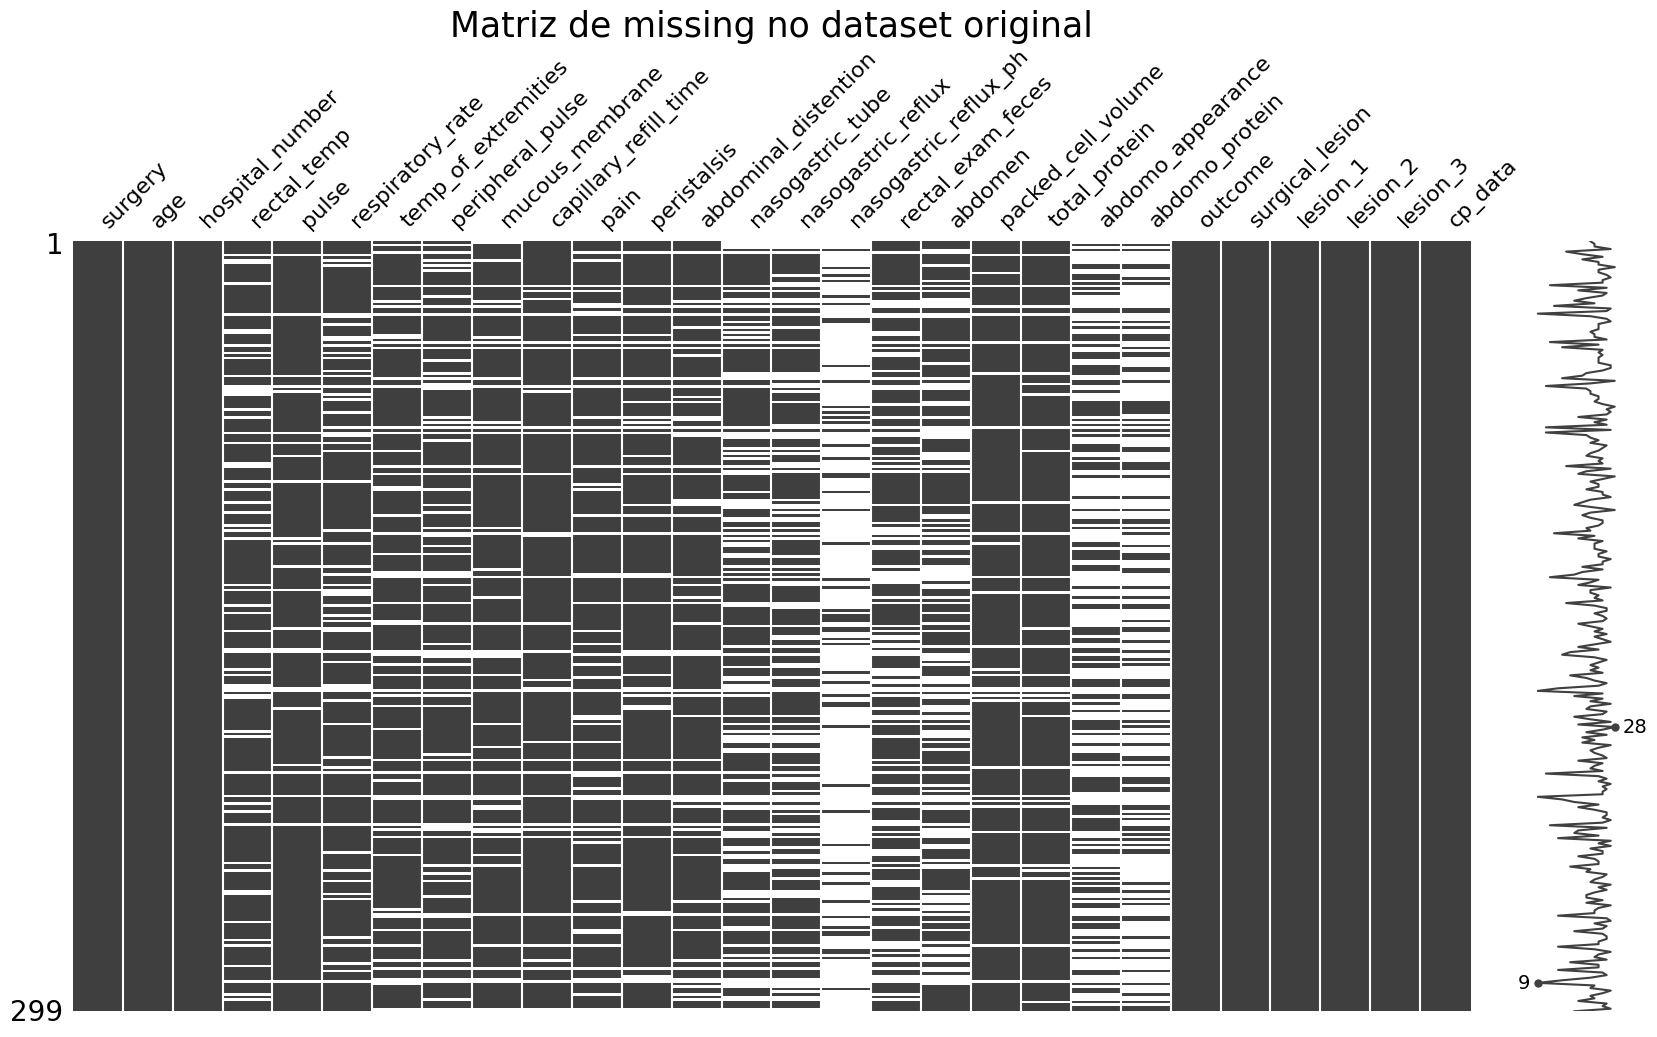

In [7]:
msno.matrix(data,figsize = (20,10))
plt.title("Matriz de missing no dataset original",fontsize = 25)

# Tratando missing de atributos com muitos dados faltantes

In [8]:
missing_analysis(data)

nasogastric_reflux_ph    82.274247
abdomo_protein           66.220736
abdomo_appearance        55.183946
abdomen                  39.464883
nasogastric_reflux       35.451505
nasogastric_tube         34.782609
rectal_exam_feces        34.113712
peripheral_pulse         23.076923
rectal_temp              20.066890
respiratory_rate         19.397993
temp_of_extremities      18.729097
abdominal_distention     18.729097
pain                     18.394649
mucous_membrane          15.719064
peristalsis              14.715719
total_protein            11.036789
capillary_refill_time    10.702341
packed_cell_volume        9.698997
pulse                     8.026756
lesion_2                  0.000000
surgical_lesion           0.000000
lesion_3                  0.000000
lesion_1                  0.000000
surgery                   0.000000
outcome                   0.000000
age                       0.000000
hospital_number           0.000000
cp_data                   0.000000
dtype: float64

### Será excluída toda coluna com mais de 50% de dados faltando para o primeiro modelo.
### Posteriormente serão testadas outras possibilidades.

In [9]:
data, removed  = good_data(data)

## Depois de remover dados com muitos missings, preencher os restantes e corrigir formatação

### Colunas removidas

In [10]:
removed

Index(['nasogastric_reflux_ph', 'abdomo_protein', 'abdomo_appearance'], dtype='object')

### Corrigindo formatação dos dados restantes

### OBS: A coluna total protein contém dados em formato de data, nesses casos o valor foi ignorado e preenchido como Nan

In [11]:
data_model = convert_columns_to_numeric(data,["total_protein","rectal_temp","respiratory_rate","packed_cell_volume","pulse"])

In [12]:
data_model

,abdomen,nasogastric_reflux,nasogastric_tube,rectal_exam_feces,peripheral_pulse,rectal_temp,respiratory_rate,temp_of_extremities,abdominal_distention,pain,mucous_membrane,peristalsis,total_protein,capillary_refill_time,packed_cell_volume,pulse,lesion_2,surgical_lesion,lesion_3,lesion_1,surgery,outcome,age,hospital_number,cp_data
0,distend_large,NaN,NaN,decreased,reduced,38.5,28.0,cool,severe,extreme_pain,NaN,absent,NaN,more_3_sec,45.0,66.0,0,no,0,11300,no,died,adult,530101,no
1,other,NaN,NaN,absent,NaN,39.2,20.0,NaN,slight,mild_pain,pale_cyanotic,absent,85.0,less_3_sec,50.0,88.0,0,no,0,2208,yes,euthanized,adult,534817,no
2,normal,NaN,NaN,normal,normal,38.3,24.0,normal,none,mild_pain,pale_pink,hypomotile,NaN,less_3_sec,33.0,40.0,0,no,0,0,no,lived,adult,530334,yes
3,NaN,less_1_liter,none,decreased,normal,39.1,84.0,cold,severe,depressed,dark_cyanotic,absent,NaN,more_3_sec,48.0,164.0,0,yes,0,2208,yes,died,young,5290409,yes
4,NaN,NaN,NaN,NaN,NaN,37.3,35.0,NaN,NaN,NaN,dark_cyanotic,NaN,NaN,more_3_sec,74.0,104.0,0,no,0,4300,no,died,adult,530255,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,distend_large,NaN,NaN,NaN,NaN,NaN,70.0,cold,NaN,depressed,pale_cyanotic,absent,65.0,more_3_sec,55.0,120.0,0,no,0,3205,yes,euthanized,adult,533886,no
295,distend_small,none,significant,absent,increased,37.2,24.0,cool,moderate,severe_pain,pale_cyanotic,hypomotile,NaN,more_3_sec,44.0,72.0,0,yes,0,2208,no,euthanized,adult,527702,yes
296,distend_large,none,slight,decreased,reduced,37.5,30.0,cold,moderate,severe_pain,pale_cyanotic,absent,NaN,less_3_sec,60.0,72.0,0,yes,0,3205,yes,died,adult,529386,no
297,distend_small,none,significant,absent,reduced,36.5,24.0,cool,moderate,mild_pain,pale_pink,hypomotile,6.0,less_3_sec,50.0,100.0,0,yes,0,2208,yes,lived,adult,530612,yes


In [50]:
data_model_good, removed_post = good_data(data_model)

In [52]:
removed += removed_post

Index(['total_protein'], dtype='object')

### Depois de transformar em dados numéricos a coluna total protein foi removida pq tinha muitos dados no formato de data que quando convertidos geraram Nans (missing > 50)

# Tratamento de missing dos atributos numéricos

### Determinando colunas com dados numéricos para tratamento

In [14]:
colunas_numericas = list(data_model_good.select_dtypes(include = ["number"]).columns)
colunas_numericas

['rectal_temp',
 'respiratory_rate',
 'packed_cell_volume',
 'pulse',
 'lesion_2',
 'lesion_3',
 'lesion_1',
 'hospital_number']

In [15]:
medianas = data_model_good[colunas_numericas].median()

data_model_good[colunas_numericas] = data_model_good[colunas_numericas].fillna(medianas)

In [16]:
data_model_good

,abdomen,nasogastric_reflux,nasogastric_tube,rectal_exam_feces,peripheral_pulse,rectal_temp,respiratory_rate,temp_of_extremities,abdominal_distention,pain,mucous_membrane,peristalsis,capillary_refill_time,packed_cell_volume,pulse,lesion_2,surgical_lesion,lesion_3,lesion_1,surgery,outcome,age,hospital_number,cp_data
0,distend_large,NaN,NaN,decreased,reduced,38.5,28.0,cool,severe,extreme_pain,NaN,absent,more_3_sec,45.0,66.0,0,no,0,11300,no,died,adult,530101,no
1,other,NaN,NaN,absent,NaN,39.2,20.0,NaN,slight,mild_pain,pale_cyanotic,absent,less_3_sec,50.0,88.0,0,no,0,2208,yes,euthanized,adult,534817,no
2,normal,NaN,NaN,normal,normal,38.3,24.0,normal,none,mild_pain,pale_pink,hypomotile,less_3_sec,33.0,40.0,0,no,0,0,no,lived,adult,530334,yes
3,NaN,less_1_liter,none,decreased,normal,39.1,84.0,cold,severe,depressed,dark_cyanotic,absent,more_3_sec,48.0,164.0,0,yes,0,2208,yes,died,young,5290409,yes
4,NaN,NaN,NaN,NaN,NaN,37.3,35.0,NaN,NaN,NaN,dark_cyanotic,NaN,more_3_sec,74.0,104.0,0,no,0,4300,no,died,adult,530255,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,distend_large,NaN,NaN,NaN,NaN,38.2,70.0,cold,NaN,depressed,pale_cyanotic,absent,more_3_sec,55.0,120.0,0,no,0,3205,yes,euthanized,adult,533886,no
295,distend_small,none,significant,absent,increased,37.2,24.0,cool,moderate,severe_pain,pale_cyanotic,hypomotile,more_3_sec,44.0,72.0,0,yes,0,2208,no,euthanized,adult,527702,yes
296,distend_large,none,slight,decreased,reduced,37.5,30.0,cold,moderate,severe_pain,pale_cyanotic,absent,less_3_sec,60.0,72.0,0,yes,0,3205,yes,died,adult,529386,no
297,distend_small,none,significant,absent,reduced,36.5,24.0,cool,moderate,mild_pain,pale_pink,hypomotile,less_3_sec,50.0,100.0,0,yes,0,2208,yes,lived,adult,530612,yes


In [17]:
missing_analysis(data_model_good[colunas_numericas])

rectal_temp           0.0
respiratory_rate      0.0
packed_cell_volume    0.0
pulse                 0.0
lesion_2              0.0
lesion_3              0.0
lesion_1              0.0
hospital_number       0.0
dtype: float64

# Tratamento de missing de dados categóricos

### Determinando colunas categóricas para tratamento

In [18]:
colunas_object= list(data_model_good[[coluna for coluna in data_model_good.columns if coluna not in colunas_numericas]].columns)
colunas_object

['abdomen',
 'nasogastric_reflux',
 'nasogastric_tube',
 'rectal_exam_feces',
 'peripheral_pulse',
 'temp_of_extremities',
 'abdominal_distention',
 'pain',
 'mucous_membrane',
 'peristalsis',
 'capillary_refill_time',
 'surgical_lesion',
 'surgery',
 'outcome',
 'age',
 'cp_data']

### Preenchendo dados com a MODA

In [19]:
for coluna in colunas_object:
    data_model_good[coluna] = data_model_good[coluna].fillna(data_model_good[coluna].mode()[0])

In [55]:
missing_analysis(data_model_good)

abdomen                  39.464883
nasogastric_reflux       35.451505
nasogastric_tube         34.782609
rectal_exam_feces        34.113712
peripheral_pulse         23.076923
rectal_temp              20.066890
respiratory_rate         19.397993
temp_of_extremities      18.729097
abdominal_distention     18.729097
pain                     18.394649
mucous_membrane          15.719064
peristalsis              14.715719
capillary_refill_time    10.702341
packed_cell_volume       10.033445
pulse                     8.026756
lesion_2                  0.000000
surgical_lesion           0.000000
lesion_3                  0.000000
lesion_1                  0.000000
surgery                   0.000000
outcome                   0.000000
age                       0.000000
hospital_number           0.000000
cp_data                   0.000000
dtype: float64

Text(0.5, 1.0, 'Dados preenchidos no data set para o modelo')

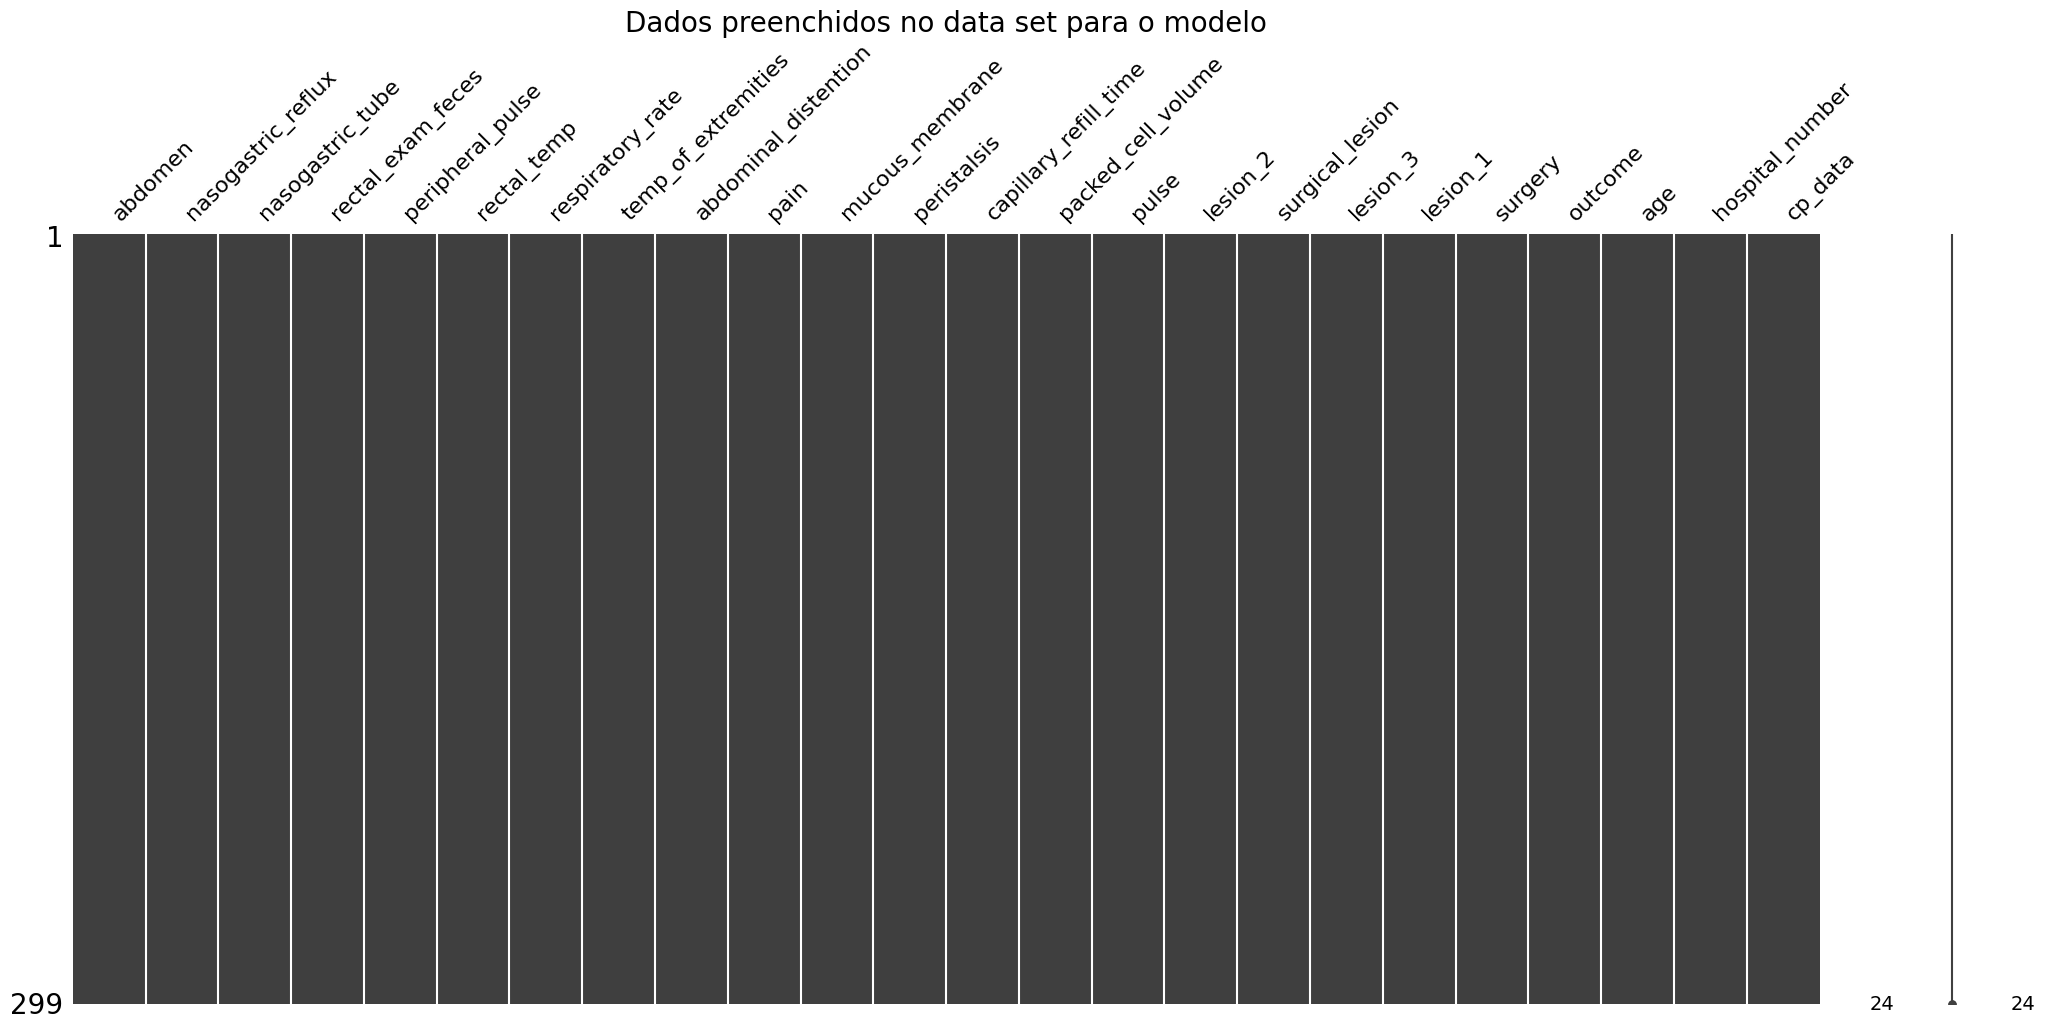

In [20]:
msno.matrix(data_model_good)
plt.title("Dados preenchidos no data set para o modelo",fontsize = 20)

# Preparando dados e testando modelos
## Transformando dados categóricos em numéricos

In [21]:
colunas_object.remove("outcome")

In [22]:
features = data_model_good.drop("outcome",axis=1)
labels = data_model_good.outcome

In [23]:
for coluna in colunas_object:
    features[coluna] = features[coluna].astype(str)

#### LabelEncoder nas labels

In [24]:
# Instanciar e ajustar o LabelEncoder ao target
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)

### Criando pipeline com encoder pras colunas de dados categóricos

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(), colunas_object)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(min_samples_leaf=5))
])

X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)


### Treinando e testando acurácia

In [26]:
pipeline.fit(X_train, y_train)

# Avaliar o modelo no conjunto de teste
score = pipeline.score(X_test, y_test)
print(f'Acurácia do modelo: {score:.4f}')


Acurácia do modelo: 0.6667


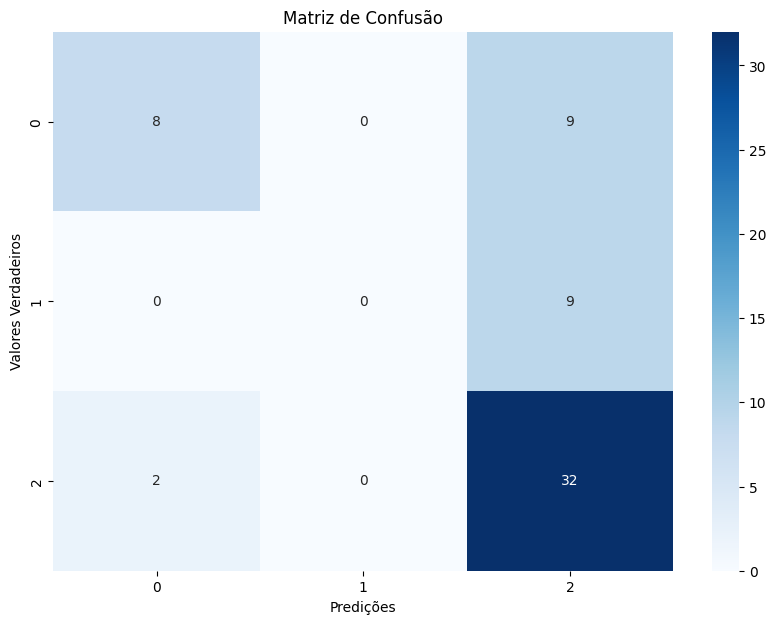

In [27]:
y_pred = pipeline.predict(X_test)

matriz_confusao = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", 
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predições')
plt.ylabel('Valores Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

In [28]:
encoder.inverse_transform(pipeline.predict(X_test))

array(['died', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived',
       'lived', 'lived', 'died', 'lived', 'lived', 'lived', 'lived',
       'lived', 'lived', 'died', 'lived', 'lived', 'lived', 'lived',
       'lived', 'lived', 'died', 'lived', 'lived', 'died', 'lived',
       'lived', 'lived', 'lived', 'died', 'lived', 'lived', 'died',
       'lived', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived',
       'lived', 'lived', 'lived', 'lived', 'died', 'lived', 'lived',
       'lived', 'lived', 'lived', 'lived', 'lived', 'lived', 'lived',
       'died', 'lived', 'lived', 'died'], dtype=object)

### Modelo de RandomForest performou mal, procurando melhores parâmetros

In [29]:
# Definir o grid de parâmetros a ser testado
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Ajustar o modelo
grid_search.fit(X_train, y_train)

# Melhores parâmetros e pontuação
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação de cross-validation:", grid_search.best_score_)

Melhores parâmetros: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Melhor pontuação de cross-validation: 0.7028368794326242


In [30]:
unique_val, cont = np.unique(y_train, return_counts=True)

In [31]:
unique_val

array([0, 1, 2])

In [32]:
cont

array([ 60,  35, 144], dtype=int64)

#### Dados desbalanceados

# Treinando Modelo com dados balanceados

### Utilizando Synthetic Minority Oversampling Technique (SMOTE) para melhorar performance do modelo

#### Aplicando preprocessamento manualmente para usar o SMOTE

In [33]:
X_train_transf = preprocessor.fit_transform(X_train)

In [34]:
X_train_transf.shape

(239, 61)

### Aplicando SMOTE para gerar dados sintéticos

In [35]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transf, y_train)

#### Convertendo saída do SMOTE em df para continuar sendo possível aplicar o ColumnTransformer por coluna da pipeline

In [36]:
y_train_smote = pd.Series(y_train_smote)
y_train_smote.value_counts()

2    144
0    144
1    144
Name: count, dtype: int64

In [37]:
model = pipeline.named_steps["classifier"]

In [38]:
clf_smote = model.fit(X_train_smote,y_train_smote)

In [39]:
X_test_transf = preprocessor.transform(X_test)

In [42]:
pred_smote = clf_smote.predict(X_test_transf)

In [43]:
y_test

array([0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0,
       2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0])

In [44]:
# Avaliar o modelo no conjunto de teste
score = clf_smote.score(X_test_transf, y_test)
print(f'Acurácia do modelo: {score:.4f}')

Acurácia do modelo: 0.7167


In [47]:
# Definir o grid de parâmetros a ser testado
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Criar o objeto GridSearchCV
grid_search_smote = GridSearchCV(clf_smote, param_grid, cv=5, scoring='accuracy')

# Ajustar o modelo
grid_search_smote.fit(X_train_smote, y_train_smote)

# Melhores parâmetros e pontuação
print("Melhores parâmetros:", grid_search_smote.best_params_)
print("Melhor pontuação de cross-validation:", grid_search_smote.best_score_)

Melhores parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Melhor pontuação de cross-validation: 0.8822240042769313


In [48]:
encoder.inverse_transform(clf_smote.predict(X_test_transf))

array(['died', 'lived', 'euthanized', 'lived', 'lived', 'lived', 'died',
       'died', 'lived', 'euthanized', 'euthanized', 'lived', 'euthanized',
       'lived', 'died', 'lived', 'died', 'euthanized', 'euthanized',
       'lived', 'lived', 'lived', 'died', 'died', 'lived', 'lived',
       'died', 'lived', 'lived', 'lived', 'lived', 'died', 'lived',
       'euthanized', 'died', 'lived', 'died', 'lived', 'lived', 'lived',
       'died', 'died', 'lived', 'lived', 'lived', 'lived', 'died',
       'lived', 'euthanized', 'lived', 'lived', 'died', 'died', 'lived',
       'lived', 'died', 'died', 'lived', 'lived', 'died'], dtype=object)